Import Libraries

In [ ]:
!python -m spacy download en_core_web_trf

In [ ]:
!pip install textblob

In [ ]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
import wordcloud
from wordcloud import WordCloud
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
lm = WordNetLemmatizer()
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

Import Data

In [4]:
#Import Amazon Review Data for the mobile Redmi Note 10
redmi= pd.read_excel('/content/amazon_review_latest.xlsx')
redmi.head(15)

,aiconalt,View1
0,1.0 out of 5 stars,"Waste mobile, Touch not working and hanging,,..."
1,3.0 out of 5 stars,"The features are good,\nI have observed below ..."
2,3.0 out of 5 stars,"Basically a 15k-18k phone sold for 21k, sound ..."
3,4.0 out of 5 stars,When I ordered it I got afraid by reading som...
4,1.0 out of 5 stars,Worst camera experience
5,1.0 out of 5 stars,Don't buy this phone there is many other good ...
6,1.0 out of 5 stars,Mobile shuts downs automatically. When it happ...
7,4.0 out of 5 stars,"idk why the camera quality degraded so much , ..."
8,1.0 out of 5 stars,I have Purchased this mobile on 15 March & rec...
9,2.0 out of 5 stars,"Camera is very very bad, don't buy just lookin..."


In [5]:
#Import Stop Words
stop_words=pd.read_csv('/content/stop.txt',header=None,)
stop_words=stop_words[0]
stop_words

0               a
1             a's
2            able
3           about
4           above
          ...    
566         yours
567      yourself
568    yourselves
569             z
570          zero
Name: 0, Length: 571, dtype: object

In [6]:
#Import list of positive words. Set the values as 1
positive_words = pd.read_csv('/content/positive-words.txt',header=None)
positive_words['value']=1
positive_words.head()

,0,value
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


In [7]:
#Import list of negative words. Set the values as -1
negative_words = pd.read_csv('/content/negative-words.txt',header=None)
negative_words['value']=-1
negative_words.head()

,0,value
0,2-faced,-1
1,2-faces,-1
2,abnormal,-1
3,abolish,-1
4,abominable,-1


Data Understanding

In [8]:
redmi.shape

(886, 2)

In [9]:
redmi.dtypes

aiconalt    object
View1       object
dtype: object

In [10]:
redmi.isna().sum()

aiconalt    0
View1       0
dtype: int64

In [11]:
redmi[redmi.duplicated()]

,aiconalt,View1
884,1.0 out of 5 stars,"Calls will not be visible in the screen, we ha..."


In [12]:
positive_words.shape

(2006, 2)

In [13]:
negative_words.shape

(4783, 2)

In [14]:
stop_words.shape

(571,)

Data Preparation

In [15]:
#Droping duplicate rows
redmi=redmi.drop_duplicates()
redmi.shape

(885, 2)

In [16]:
redmi=redmi.rename({'aiconalt':'Ratings','View1':'Review'},axis=1)
redmi.head()

,Ratings,Review
0,1.0 out of 5 stars,"Waste mobile, Touch not working and hanging,,..."
1,3.0 out of 5 stars,"The features are good,\nI have observed below ..."
2,3.0 out of 5 stars,"Basically a 15k-18k phone sold for 21k, sound ..."
3,4.0 out of 5 stars,When I ordered it I got afraid by reading som...
4,1.0 out of 5 stars,Worst camera experience


In [17]:
redmi['Ratings'].value_counts()

1.0 out of 5 stars    382
3.0 out of 5 stars    158
5.0 out of 5 stars    145
4.0 out of 5 stars    102
2.0 out of 5 stars     98
Name: Ratings, dtype: int64

In [18]:
def label_encoder(x):
  if x == '1.0 out of 5 stars':
    return 1
  elif x=='2.0 out of 5 stars':
    return 2
  elif x=='3.0 out of 5 stars':
    return 3
  elif x=='4.0 out of 5 stars':
    return 4
  elif x=='5.0 out of 5 stars':
    return 5
  else:
    pass

In [19]:
redmi['Ratings'] = redmi['Ratings'].apply(lambda x: label_encoder(x))

In [20]:
redmi.head()

,Ratings,Review
0,1,"Waste mobile, Touch not working and hanging,,..."
1,3,"The features are good,\nI have observed below ..."
2,3,"Basically a 15k-18k phone sold for 21k, sound ..."
3,4,When I ordered it I got afraid by reading som...
4,1,Worst camera experience


In [21]:
#Combining both positive and negative words and making it a dictionary.
positive_negative = pd.concat([positive_words,negative_words])
positive_negative_words=positive_negative.set_index(0)['value'].to_dict()
positive_negative_words

{'a+': 1,
 'abound': 1,
 'abounds': 1,
 'abundance': 1,
 'abundant': 1,
 'accessable': 1,
 'accessible': 1,
 'acclaim': 1,
 'acclaimed': 1,
 'acclamation': 1,
 'accolade': 1,
 'accolades': 1,
 'accommodative': 1,
 'accomodative': 1,
 'accomplish': 1,
 'accomplished': 1,
 'accomplishment': 1,
 'accomplishments': 1,
 'accurate': 1,
 'accurately': 1,
 'achievable': 1,
 'achievement': 1,
 'achievements': 1,
 'achievible': 1,
 'acumen': 1,
 'adaptable': 1,
 'adaptive': 1,
 'adequate': 1,
 'adjustable': 1,
 'admirable': 1,
 'admirably': 1,
 'admiration': 1,
 'admire': 1,
 'admirer': 1,
 'admiring': 1,
 'admiringly': 1,
 'adorable': 1,
 'adore': 1,
 'adored': 1,
 'adorer': 1,
 'adoring': 1,
 'adoringly': 1,
 'adroit': 1,
 'adroitly': 1,
 'adulate': 1,
 'adulation': 1,
 'adulatory': 1,
 'advanced': 1,
 'advantage': 1,
 'advantageous': 1,
 'advantageously': 1,
 'advantages': 1,
 'adventuresome': 1,
 'adventurous': 1,
 'advocate': 1,
 'advocated': 1,
 'advocates': 1,
 'affability': 1,
 'affable'

In [22]:
#Word frequency before Removing Stop Words
pd.Series(''.join(redmi['Review']).split()).value_counts()[0:20]

is         1469
the         798
and         786
this        662
not         639
phone       631
to          575
I           498
in          442
camera      435
for         433
of          411
a           378
it          370
quality     329
very        320
but         294
good        283
with        274
are         210
dtype: int64

In [23]:
def clean_review(review):
  """Make the text lowercase, remove text in square brackets, punctuations and special characters 
  """
  review=review.lower()
  review=re.sub('\[.*?\]',' ',review)
  review=re.sub('[%s]'%re.escape(string.punctuation),' ',review)
  review=re.sub('\w*\d\w*',' ',review)
  review = re.sub("[0-9" "]+"," ",review)
  review = re.sub('[‘’“”…]', '', review)
  review=re.sub('https:\ $',' ',review)
  review=re.sub('http',' ',review)
  review=re.sub(" _'_ ",' ',review)
  review=review.split()
  review=[lm.lemmatize(word) for word in review if word not in stop_words.values]
  review=' '.join(review)
  return review

clean = lambda x: clean_review(x)

In [24]:
redmi['Review']=redmi['Review'].apply(clean)
redmi.head()

,Ratings,Review
0,1,waste mobile touch working hanging don mi prod...
1,3,feature good observed issue phone redmi note p...
2,3,basically phone sold sound surely good loud lo...
3,4,ordered afraid reading negative review day hon...
4,1,worst camera experience


In [25]:
#Word frequency After Removing Stop Words
pd.Series(''.join(redmi['Review']).split()).value_counts()[0:20]

phone       853
camera      702
good        483
quality     396
battery     253
redmi       207
mobile      197
screen      197
note        188
pro         183
call        182
issue       169
day         163
don         152
buy         146
time        143
display     142
charging    139
bad         124
worst       123
dtype: int64

In [26]:
#Get the subjectivity and Polarity
def sentimental_analysis(redmi):
  senti=TextBlob(redmi['Review']).sentiment
  return pd.Series([senti.subjectivity,senti.polarity])

redmi[['Subjectivity','Polarity']] = redmi.apply(sentimental_analysis,axis=1)
redmi.head()

,Ratings,Review,Subjectivity,Polarity
0,1,waste mobile touch working hanging don mi prod...,0.303571,-0.192857
1,3,feature good observed issue phone redmi note p...,0.476923,0.046154
2,3,basically phone sold sound surely good loud lo...,0.520476,0.173333
3,4,ordered afraid reading negative review day hon...,0.656410,0.316667
4,1,worst camera experience,1.000000,-1.000000


In [27]:
def analysis(score):
  if score<0:
    return 'Negative'
  elif score==0:
    return 'Neutral'
  else:
    return 'Positive'

redmi['Analysis']= redmi['Polarity'].apply(analysis)
redmi.head()

,Ratings,Review,Subjectivity,Polarity,Analysis
0,1,waste mobile touch working hanging don mi prod...,0.303571,-0.192857,Negative
1,3,feature good observed issue phone redmi note p...,0.476923,0.046154,Positive
2,3,basically phone sold sound surely good loud lo...,0.520476,0.173333,Positive
3,4,ordered afraid reading negative review day hon...,0.656410,0.316667,Positive
4,1,worst camera experience,1.000000,-1.000000,Negative


In [28]:
vect=CountVectorizer(min_df=1,max_df=0.8)
X = vect.fit_transform(redmi['Review'])
vect_df=pd.DataFrame()
vect_df['Term']=vect.get_feature_names_out()
vect_df['Occurence']=np.asarray(X.sum(axis=0)).ravel().tolist()
vect_df['Frequency']=vect_df['Occurence']/np.sum(vect_df['Occurence'])
vect_df.sort_values(by='Occurence')

,Term,Occurence,Frequency
2841,ᴡɪᴛʜ,1,0.000051
1218,isme,1,0.000051
1216,iske,1,0.000051
1214,isiliye,1,0.000051
1213,ish,1,0.000051
...,...,...,...
198,battery,290,0.014849
1899,quality,405,0.020737
976,good,551,0.028213
339,camera,792,0.040553


In [29]:
vect_tfid=TfidfVectorizer(max_features=1000,max_df=0.5,stop_words='english',smooth_idf=True)
Y=vect_tfid.fit_transform(redmi['Review'])
features=vect_tfid.get_feature_names_out()
vect_tfid_df=pd.DataFrame(Y.todense().tolist(),columns=features)
vect_tfid_df.head()

,aa,aaj,aap,abhi,absolutely,accha,accurate,acha,achha,act,...,पहल,बर,बह,मन,मर,शन,सर,ᴀɴʏ,ᴛᴏ,ᴜsᴇ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
vect_tfid_df.shape

(885, 1000)

N - Grams

Bi-Gram

In [31]:
def get_top_n_words(df,n=None,ngram=None):
  vect_bigrams=CountVectorizer(max_features=2000,ngram_range=ngram).fit(df)
  bag_of_words=vect_bigrams.transform(df)
  sum_of_words=bag_of_words.sum(axis=0)
  word_frequency=[(word,sum_of_words[0,idx]) for word,idx in vect_bigrams.vocabulary_.items()]
  word_frequency=sorted(word_frequency,key=lambda x : x[1],reverse=True)
  return word_frequency[:n]

In [32]:
top_2=get_top_n_words(redmi['Review'],n=200,ngram=(2,2))
top_2_df=pd.DataFrame(top_2,columns=['bi-gram','frequency'])
top_2_df.head()

,bi-gram,frequency
0,camera quality,200
1,note pro,135
2,redmi note,108
3,battery life,88
4,don buy,68


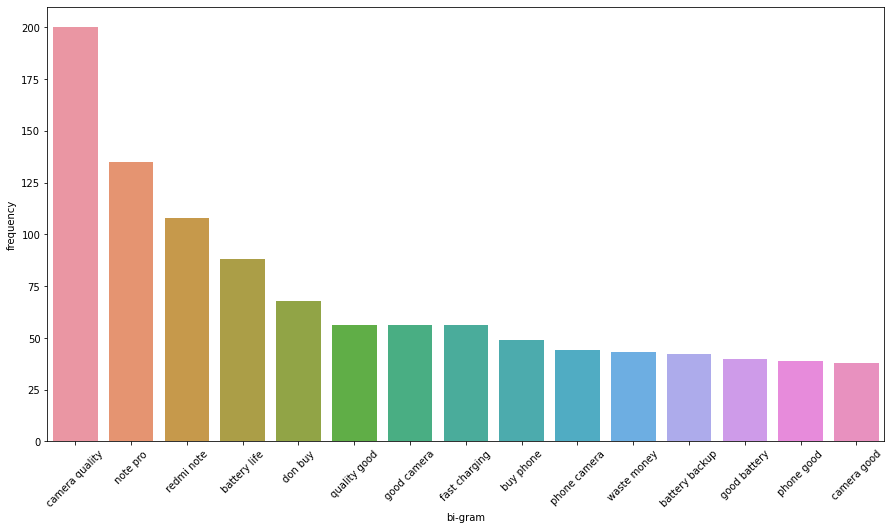

In [33]:
top_15_bigram = top_2_df.iloc[0:15,:]
plt.figure(figsize=(15,8))
fig=sns.barplot(top_15_bigram['bi-gram'],top_15_bigram['frequency'])
fig.set_xticklabels(rotation=45,labels=top_15_bigram['bi-gram'])
plt.show()

Tri-Gram

In [34]:
top_3=get_top_n_words(redmi['Review'],n=200,ngram=(3,3))
top_3_df=pd.DataFrame(top_3,columns=['Tri-gram','frequency'])
top_3_df.head()

,Tri-gram,frequency
0,redmi note pro,78
1,camera quality good,27
2,camera quality poor,24
3,battery life good,24
4,don buy phone,18


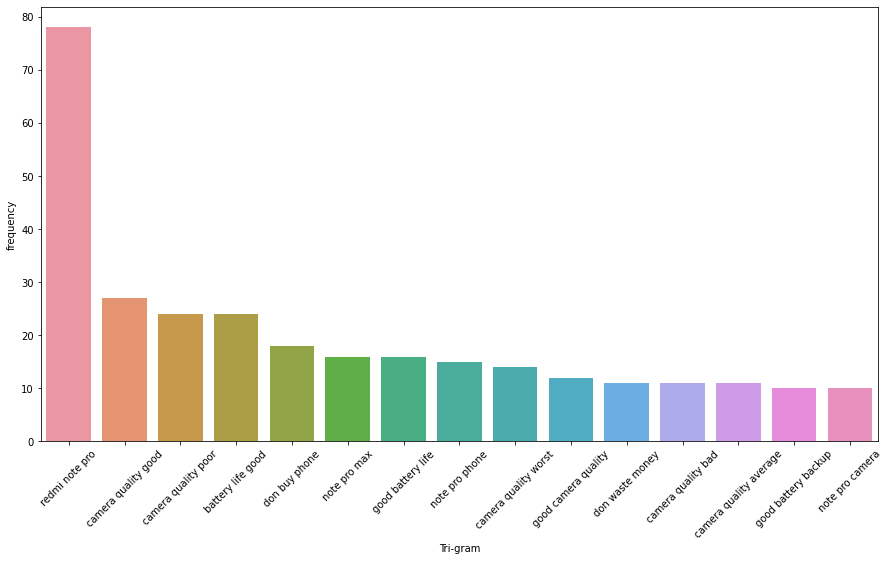

In [35]:
top_15_trigram = top_3_df.iloc[0:15,:]
plt.figure(figsize=(15,8))
fig=sns.barplot(top_15_trigram['Tri-gram'],top_15_trigram['frequency'])
fig.set_xticklabels(rotation=45,labels=top_15_trigram['Tri-gram'])
plt.show()

Word Cloud

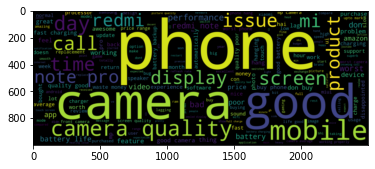

In [36]:
#From complete Reviews
string = " ".join(redmi['Review'])
word_cloud = WordCloud(width=2500,height=1000).generate(string)
plt.imshow(word_cloud,interpolation='bilinear')
plt.show()

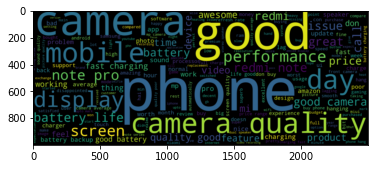

In [37]:
#From Positive Reviews
string_positive = " ".join(redmi[redmi['Analysis']=='Positive']['Review'])
word_cloud_positive = WordCloud(width=2500,height=1000).generate(string_positive)
plt.imshow(word_cloud_positive,interpolation='bilinear')
plt.show()

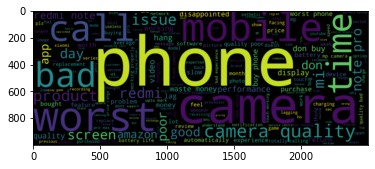

In [38]:
#From Negative Reviews
string_negative = " ".join(redmi[redmi['Analysis']=='Negative']['Review'])
word_cloud_negative = WordCloud(width=2500,height=1000).generate(string_negative)
plt.imshow(word_cloud_negative,interpolation='bilinear')
plt.show()

In [39]:
len(string_positive)/len(negative_words)

15.132552791135272

In [40]:
nlp=spacy.load('en_core_web_trf')

Calculate Sentiment Score

In [41]:
def calculate_sentiment(text: str=None):
  """This function gets the input string, Use pretrained model "en_core_web_trf" to preprocess the input string,
     Assign each word a sentiment value (+1 for positive words, -1 for negative words) sum it up for each sentence
     and return the sum value.
  """
  senti_score = 0
  if text:
    sentence = nlp(text)
    for word in sentence:
      senti_score = senti_score + positive_negative_words.get(word.lemma_,0)
  return senti_score

In [42]:
calculate_sentiment('happy')    #Validate Sentiment score for an example string - 'happy' which returns 1 (positive word)

1

In [43]:
redmi['sentiment_score']=redmi['Review'].apply(calculate_sentiment) #new column sentiment score, apply calculate_sentiment function to each sentence.

Token indices sequence length is longer than the specified maximum sequence length for this model (729 > 512). Running this sequence through the model will result in indexing errors


In [44]:
redmi.head()

,Ratings,Review,Subjectivity,Polarity,Analysis,sentiment_score
0,1,waste mobile touch working hanging don mi prod...,0.303571,-0.192857,Negative,-2
1,3,feature good observed issue phone redmi note p...,0.476923,0.046154,Positive,-2
2,3,basically phone sold sound surely good loud lo...,0.520476,0.173333,Positive,-2
3,4,ordered afraid reading negative review day hon...,0.656410,0.316667,Positive,8
4,1,worst camera experience,1.000000,-1.000000,Negative,-1


In [45]:
redmi['Word Count']= redmi['Review'].str.split().apply(len)
redmi.head()

,Ratings,Review,Subjectivity,Polarity,Analysis,sentiment_score,Word Count
0,1,waste mobile touch working hanging don mi prod...,0.303571,-0.192857,Negative,-2,18
1,3,feature good observed issue phone redmi note p...,0.476923,0.046154,Positive,-2,79
2,3,basically phone sold sound surely good loud lo...,0.520476,0.173333,Positive,-2,56
3,4,ordered afraid reading negative review day hon...,0.656410,0.316667,Positive,8,55
4,1,worst camera experience,1.000000,-1.000000,Negative,-1,3


Model Analysis and Visualization

In [46]:
redmi.sort_values(by='sentiment_score').tail(10)

,Ratings,Review,Subjectivity,Polarity,Analysis,sentiment_score,Word Count
179,5,mi phone year redmi redmi note note pro note p...,0.594505,0.535714,Positive,8,97
3,4,ordered afraid reading negative review day hon...,0.656410,0.316667,Positive,8,55
201,4,speaker fantastic strong bowing jbl dolby atmo...,0.616667,0.354167,Positive,9,28
147,5,performance superior mp wide camera superb vid...,0.608182,0.391818,Positive,10,39
237,3,budget phone handy feature nice form factor fa...,0.666667,0.386111,Positive,10,37
17,5,phone delivered yesterday feeling hold hand ex...,0.591667,0.377083,Positive,11,99
258,3,switched readmi samsung samsung good ui premiu...,0.632708,0.355313,Positive,11,48
101,4,phone good spec pretty good ui good bloatware ...,0.613690,0.323321,Positive,12,101
160,4,buy read carefully 📱 redmi note pro gb model d...,0.663333,0.265667,Positive,12,131
241,3,received product april review pro day usage ba...,0.711905,0.668347,Positive,16,85


In [47]:
redmi.sentiment_score.describe()

count    885.000000
mean       0.068927
std        2.959148
min      -11.000000
25%       -2.000000
50%        0.000000
75%        2.000000
max       16.000000
Name: sentiment_score, dtype: float64

In [48]:
redmi[redmi['sentiment_score']<=-4].head()['Review'].to_list()[0]

'phone guy performance redmi india 🇮🇳 realme oppo vivo samsung purchase redmi moving brand hopeless product waste hard earned money attached sample photo camera dasy nokia disappointed'

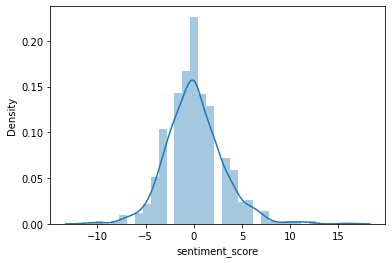

In [49]:
sns.distplot(redmi.sentiment_score)
plt.show()

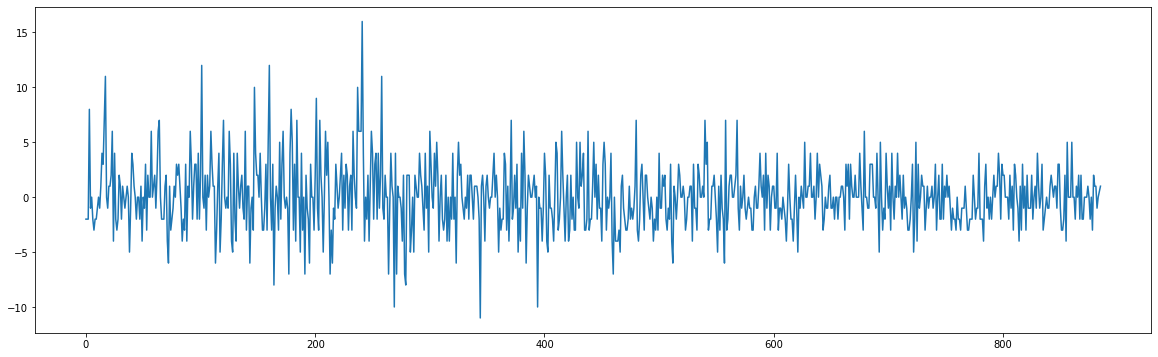

In [50]:
redmi.sentiment_score.plot(figsize=(20,6))
plt.show()

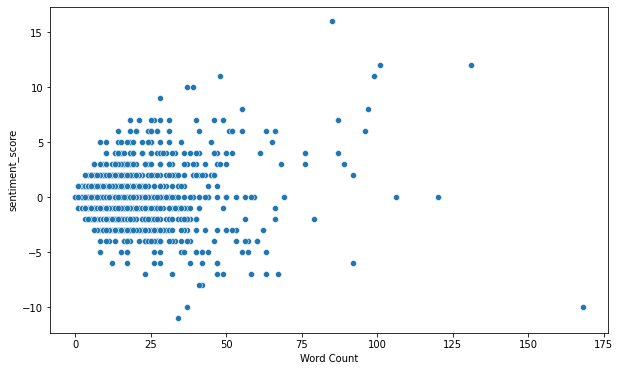

In [51]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=redmi,x='Word Count',y='sentiment_score')
plt.show()

End !!!